In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve, confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from joblib import Parallel, delayed
from sklearn.datasets import make_classification

In [2]:
f1=pd.read_csv('contract.csv')
f2=pd.read_csv('internet.csv')
f3=pd.read_csv('personal.csv')
f4=pd.read_csv('phone.csv')
dataset = pd.merge(f3, f4, how='left', on='customerID')
dataset = pd.merge(dataset, f2, how='left', on='customerID')
dataset = pd.merge(dataset, f1, how='left', on='customerID')
print(dataset.shape)
dataset.head()

(7043, 20)


,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   MultipleLines     6361 non-null   object 
 6   InternetService   5517 non-null   object 
 7   OnlineSecurity    5517 non-null   object 
 8   OnlineBackup      5517 non-null   object 
 9   DeviceProtection  5517 non-null   object 
 10  TechSupport       5517 non-null   object 
 11  StreamingTV       5517 non-null   object 
 12  StreamingMovies   5517 non-null   object 
 13  BeginDate         7043 non-null   object 
 14  EndDate           7043 non-null   object 
 15  Type              7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
dataset['PaymentMethod'].value_counts().to_frame()#в основном получают электронный чек

,PaymentMethod
Electronic check,2365
Mailed check,1612
Bank transfer (automatic),1544
Credit card (automatic),1522


In [5]:
dataset['BeginDate'].value_counts().to_frame().head(20) #начало договора

,BeginDate
2014-02-01,366
2019-10-01,237
2019-11-01,237
2019-09-01,237
2020-01-01,233
2019-12-01,220
2014-03-01,178
2019-07-01,156
2019-08-01,146
2019-06-01,141


In [6]:
dataset['EndDate'].value_counts().to_frame().head(20) #конец договора

,EndDate
No,5174
2019-11-01 00:00:00,485
2019-12-01 00:00:00,466
2020-01-01 00:00:00,460
2019-10-01 00:00:00,458


count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64


<AxesSubplot:>

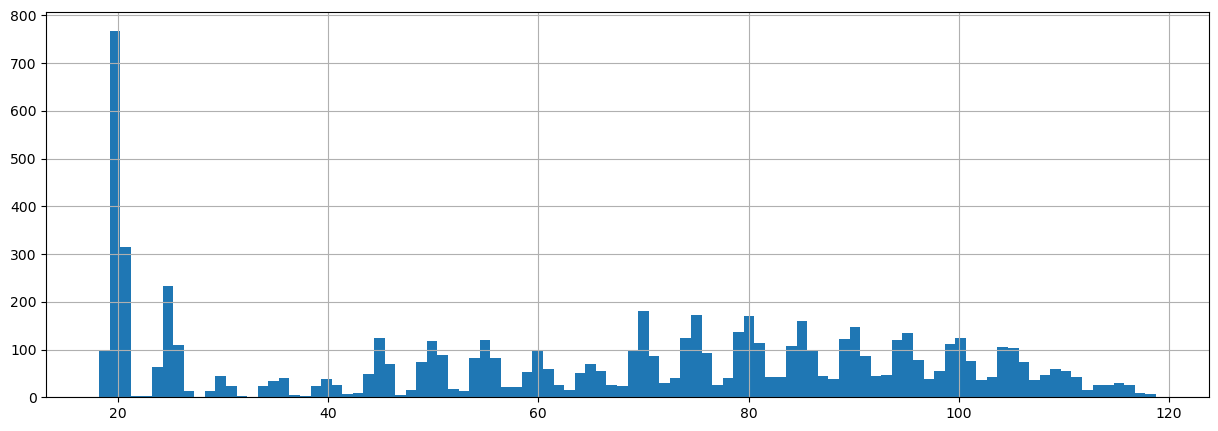

In [7]:
print(dataset['MonthlyCharges'].describe())#cсредняя: 81.76; 50%(половина): 82.5
dataset['MonthlyCharges'].hist(bins = 100,figsize = (15, 5))

In [8]:
dataset['TotalCharges'].describe()   #describe() - Описательная статистика включает те, 
                                     #которые обобщают центральную тенденцию, дисперсию и форму распределения набора данных, исключая NaN значения.

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object

In [9]:
dataset['PaperlessBilling'].value_counts().to_frame()

,PaperlessBilling
Yes,4171
No,2872


In [10]:
dataset['SeniorCitizen'].value_counts().to_frame()#старый клиент или нет

,SeniorCitizen
0,5901
1,1142


In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   MultipleLines     6361 non-null   object 
 6   InternetService   5517 non-null   object 
 7   OnlineSecurity    5517 non-null   object 
 8   OnlineBackup      5517 non-null   object 
 9   DeviceProtection  5517 non-null   object 
 10  TechSupport       5517 non-null   object 
 11  StreamingTV       5517 non-null   object 
 12  StreamingMovies   5517 non-null   object 
 13  BeginDate         7043 non-null   object 
 14  EndDate           7043 non-null   object 
 15  Type              7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
dataset = dataset.fillna('No')
def status(row):
    end_date = row['EndDate']
    if end_date == 'No':
        return '0'
    return '1'

dataset['Type'] = dataset['Type'].replace('One year', 0)
dataset['Type'] = dataset['Type'].replace('Month-to-month', 1)
dataset['Type'] = dataset['Type'].replace('Two year', 2)
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,No,DSL,No,Yes,No,No,No,No,2020-01-01,No,1,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,0,No,Mailed check,56.95,1889.5
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01 00:00:00,1,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,No,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,No,0,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,1,Yes,Electronic check,70.70,151.65


In [13]:
dataset['TotalCharges'].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [14]:
dataset['PaperlessBilling'] = dataset['PaperlessBilling'].replace('No', 0.0)
dataset['PaperlessBilling'] = dataset['PaperlessBilling'].replace('Yes', 1.0)

dataset['PaymentMethod'] = dataset['PaymentMethod'].replace('Mailed check', 0.0)
dataset['PaymentMethod'] = dataset['PaymentMethod'].replace('Electronic check', 1.0)
dataset['PaymentMethod'] = dataset['PaymentMethod'].replace('Credit card (automatic)', 2.0)
dataset['PaymentMethod'] = dataset['PaymentMethod'].replace('Bank transfer (automatic)', 3.0)

dataset['InternetService'] = dataset['InternetService'].replace('DSL', 0.0)
dataset['InternetService'] = dataset['InternetService'].replace('Fiber optic', 1.0)

dataset['OnlineSecurity'] = dataset['OnlineSecurity'].replace('No', 0.0)
dataset['OnlineSecurity'] = dataset['OnlineSecurity'].replace('Yes', 1.0)

dataset['OnlineBackup'] = dataset['OnlineBackup'].replace('No', 0.0)
dataset['OnlineBackup'] = dataset['OnlineBackup'].replace('Yes', 1.0)

dataset['DeviceProtection'] = dataset['DeviceProtection'].replace('No', 0.0)
dataset['DeviceProtection'] = dataset['DeviceProtection'].replace('Yes',1.0)

dataset['TechSupport'] = dataset['TechSupport'].replace('No', 0.0)
dataset['TechSupport'] = dataset['TechSupport'].replace('Yes', 1.0)

dataset['StreamingTV'] = dataset['StreamingTV'].replace('No', 0.0)
dataset['StreamingTV'] = dataset['StreamingTV'].replace('Yes', 1.0)

dataset['StreamingMovies'] = dataset['StreamingMovies'].replace('No',0.0)
dataset['StreamingMovies'] = dataset['StreamingMovies'].replace('Yes', 1.0)

dataset['gender'] = dataset['gender'].replace('Male', 0.0)
dataset['gender'] = dataset['gender'].replace('Female', 1.0)

dataset['Partner'] = dataset['Partner'].replace('No', 0.0)
dataset['Partner'] = dataset['Partner'].replace('Yes', 1.0)

dataset['Dependents'] = dataset['Dependents'].replace('No', 0.0)
dataset['Dependents'] = dataset['Dependents'].replace('Yes', 1.0)

dataset['MultipleLines'] = dataset['MultipleLines'].replace('No', 0.0)
dataset['MultipleLines'] = dataset['MultipleLines'].replace('Yes', 1.0)
new_type_list = []
for i in dataset['TotalCharges']:
    try:
        i = float(i)
    except:
        i = 0
    new_type_list.append(i)


dataset['Type'] = dataset['Type'].astype(float)
dataset['SeniorCitizen'] = dataset['SeniorCitizen'].astype(float)

In [15]:
# тут точно есть пробелы
(dataset['TotalCharges'] ==' ').value_counts()
dataset = dataset.loc[dataset['TotalCharges'] !=' ']
dataset['TotalCharges'] = dataset['TotalCharges'].astype('float64')

In [16]:
#целевой признак- ушел клиент или нет
dataset['churn'] = 'client_away'
dataset.loc[dataset['EndDate'] == 'No', 'churn'] = 'client_stay'
dataset['churn'].value_counts(normalize=True)

client_stay    0.734215
client_away    0.265785
Name: churn, dtype: float64

In [17]:
#у дат должен быть формат datetime
dataset['BeginDate'] = pd.to_datetime(dataset['BeginDate'], format = '%Y-%m-%d')
dataset.loc[dataset['EndDate'] == 'No', 'EndDate'] = '2020-02-01'#такая дата потому что последняя что есть в файле это 2020-01-01
dataset['EndDate'] = pd.to_datetime(dataset['EndDate'], format = '%Y-%m-%d')

In [18]:
#добавляем столбец дейсвия договора в днях то есть до каких пор клиент будет клиентом

dataset['begin_contract_year'] = pd.DatetimeIndex(dataset['BeginDate']).year #нужно знать год начала контракта
dataset['end_contract_year'] = pd.DatetimeIndex(dataset['EndDate']).year #нужно знать год конца контракта
dataset['begin_contract_month'] = pd.DatetimeIndex(dataset['BeginDate']).month #нужно знать месяц начала контракта
dataset['end_contract_month'] = pd.DatetimeIndex(dataset['EndDate']).month #нужно знать месяц конца контракта

#добавляем столбец дейсвие договора в месяцах
dataset['clienttime'] = (dataset['end_contract_year'] - dataset['begin_contract_year']) * 365 + (dataset['end_contract_month']
                - dataset['begin_contract_month']) * 30


#удаляем лишние столбцы     
dataset = dataset.drop(['end_contract_month'], axis=1)#'begin_contract_year','end_contract_year','begin_contract_month' 

In [19]:
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,begin_contract_year,end_contract_year,begin_contract_month,clienttime
0,7590-VHVEG,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,29.85,29.85,client_stay,2020,2020,1,30
1,5575-GNVDE,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,56.95,1889.50,client_stay,2017,2020,4,1035
2,3668-QPYBK,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,53.85,108.15,client_away,2019,2019,10,60
3,7795-CFOCW,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,3.0,42.30,1840.75,client_stay,2016,2020,5,1370
4,9237-HQITU,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,70.70,151.65,client_away,2019,2019,9,60


In [20]:
#нам же нужно посмотреть сколько клиентов на какие услуги подключились
dataset['services'] = 'all_services '
dataset.loc[dataset['MultipleLines'] == -1, 'services'] = 'InternetService' 
dataset.loc[dataset['InternetService'] == -1,'services'] = 'PhoneServices' 
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,begin_contract_year,end_contract_year,begin_contract_month,clienttime,services
0,7590-VHVEG,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,29.85,29.85,client_stay,2020,2020,1,30,all_services
1,5575-GNVDE,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,56.95,1889.50,client_stay,2017,2020,4,1035,all_services
2,3668-QPYBK,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,53.85,108.15,client_away,2019,2019,10,60,all_services
3,7795-CFOCW,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,3.0,42.30,1840.75,client_stay,2016,2020,5,1370,all_services
4,9237-HQITU,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,70.70,151.65,client_away,2019,2019,9,60,all_services


In [21]:
from sklearn.neighbors import KNeighborsClassifier  #Импорт классификатора "K-ближайших соседей"
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier #Импорт классификатора "Градиентный бустинг" и "Рандомный лес"
from sklearn.linear_model import LogisticRegression  #Импорт классификатора "Логистическая регрессия"
from sklearn.svm import SVC  #Импорт классификатора "Метод опорных векторов"
#Импорт методов автоматической обработки данных
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
#Импорт метрик качества классификации
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import roc_auc_score

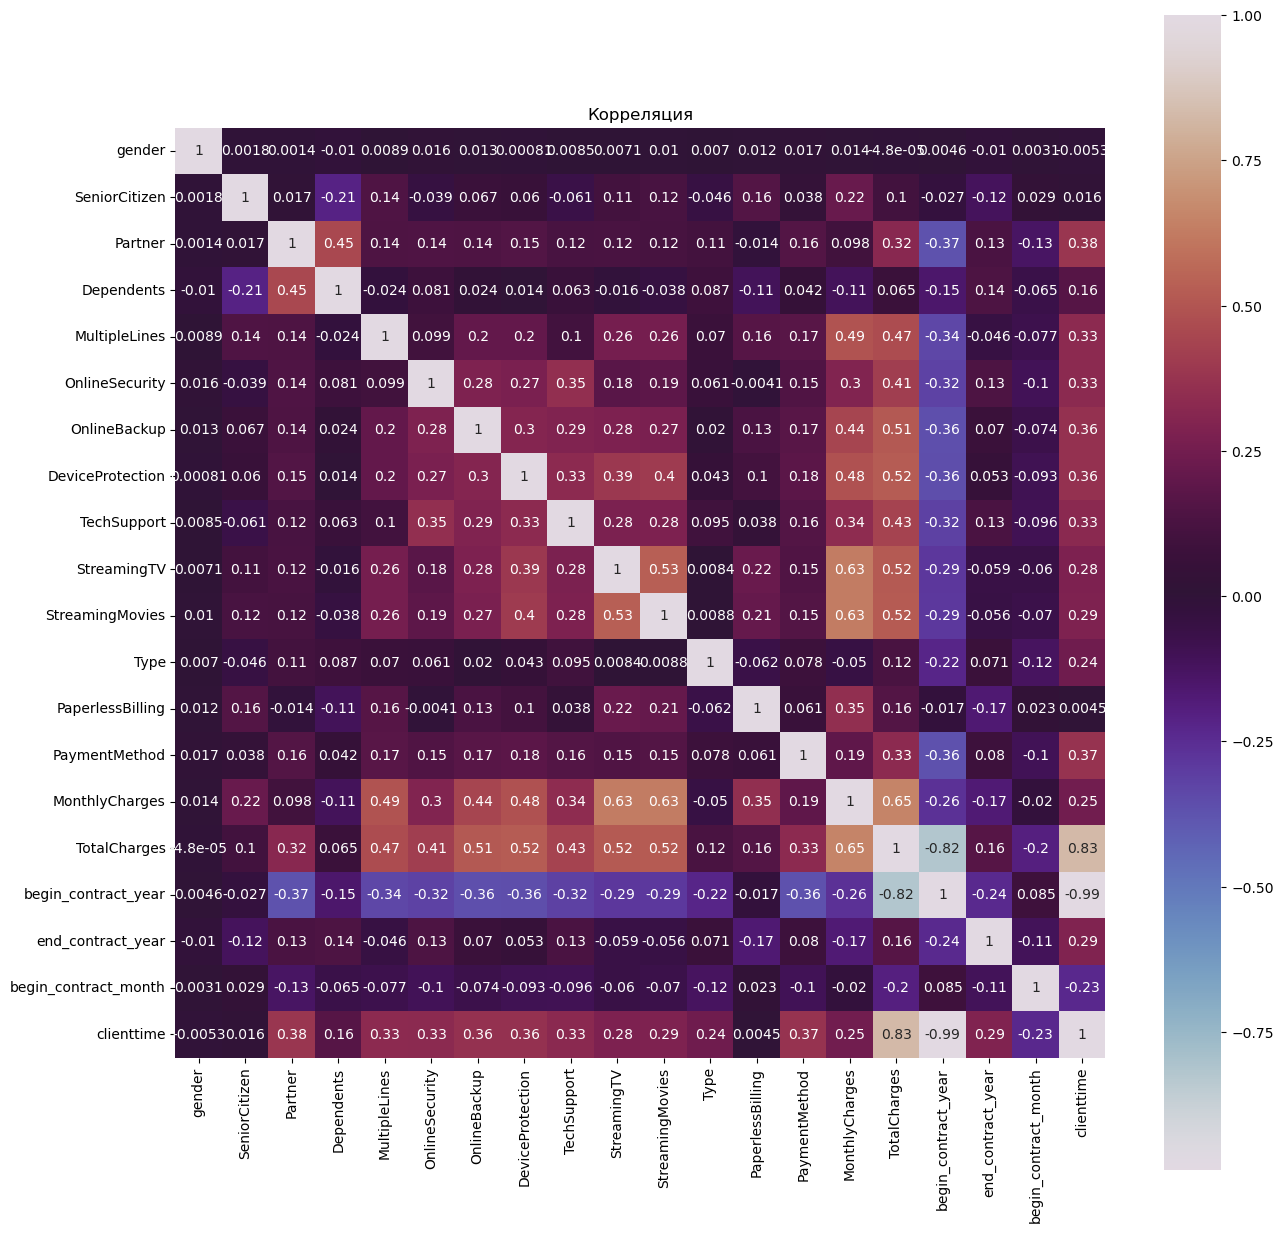

In [22]:
correlation = dataset.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='twilight')

plt.title('Корреляция')
plt.show()

In [23]:
#корреляция Пирсона
dataset[['MonthlyCharges', 'TotalCharges', 'clienttime']].corr().style.background_gradient()

,MonthlyCharges,TotalCharges,clienttime
MonthlyCharges,1.000000,0.651065,0.246465
TotalCharges,0.651065,1.000000,0.825717
clienttime,0.246465,0.825717,1.000000


In [24]:
#TotalCharges выдает 0.96 - удаляем
dataset.drop('TotalCharges', axis = 1, inplace = True)

In [25]:
cols1 = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
cols2 = ['Type', 'PaperlessBilling', 'PaymentMethod']
cols3 = ['services', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection']
cols4 = ['TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

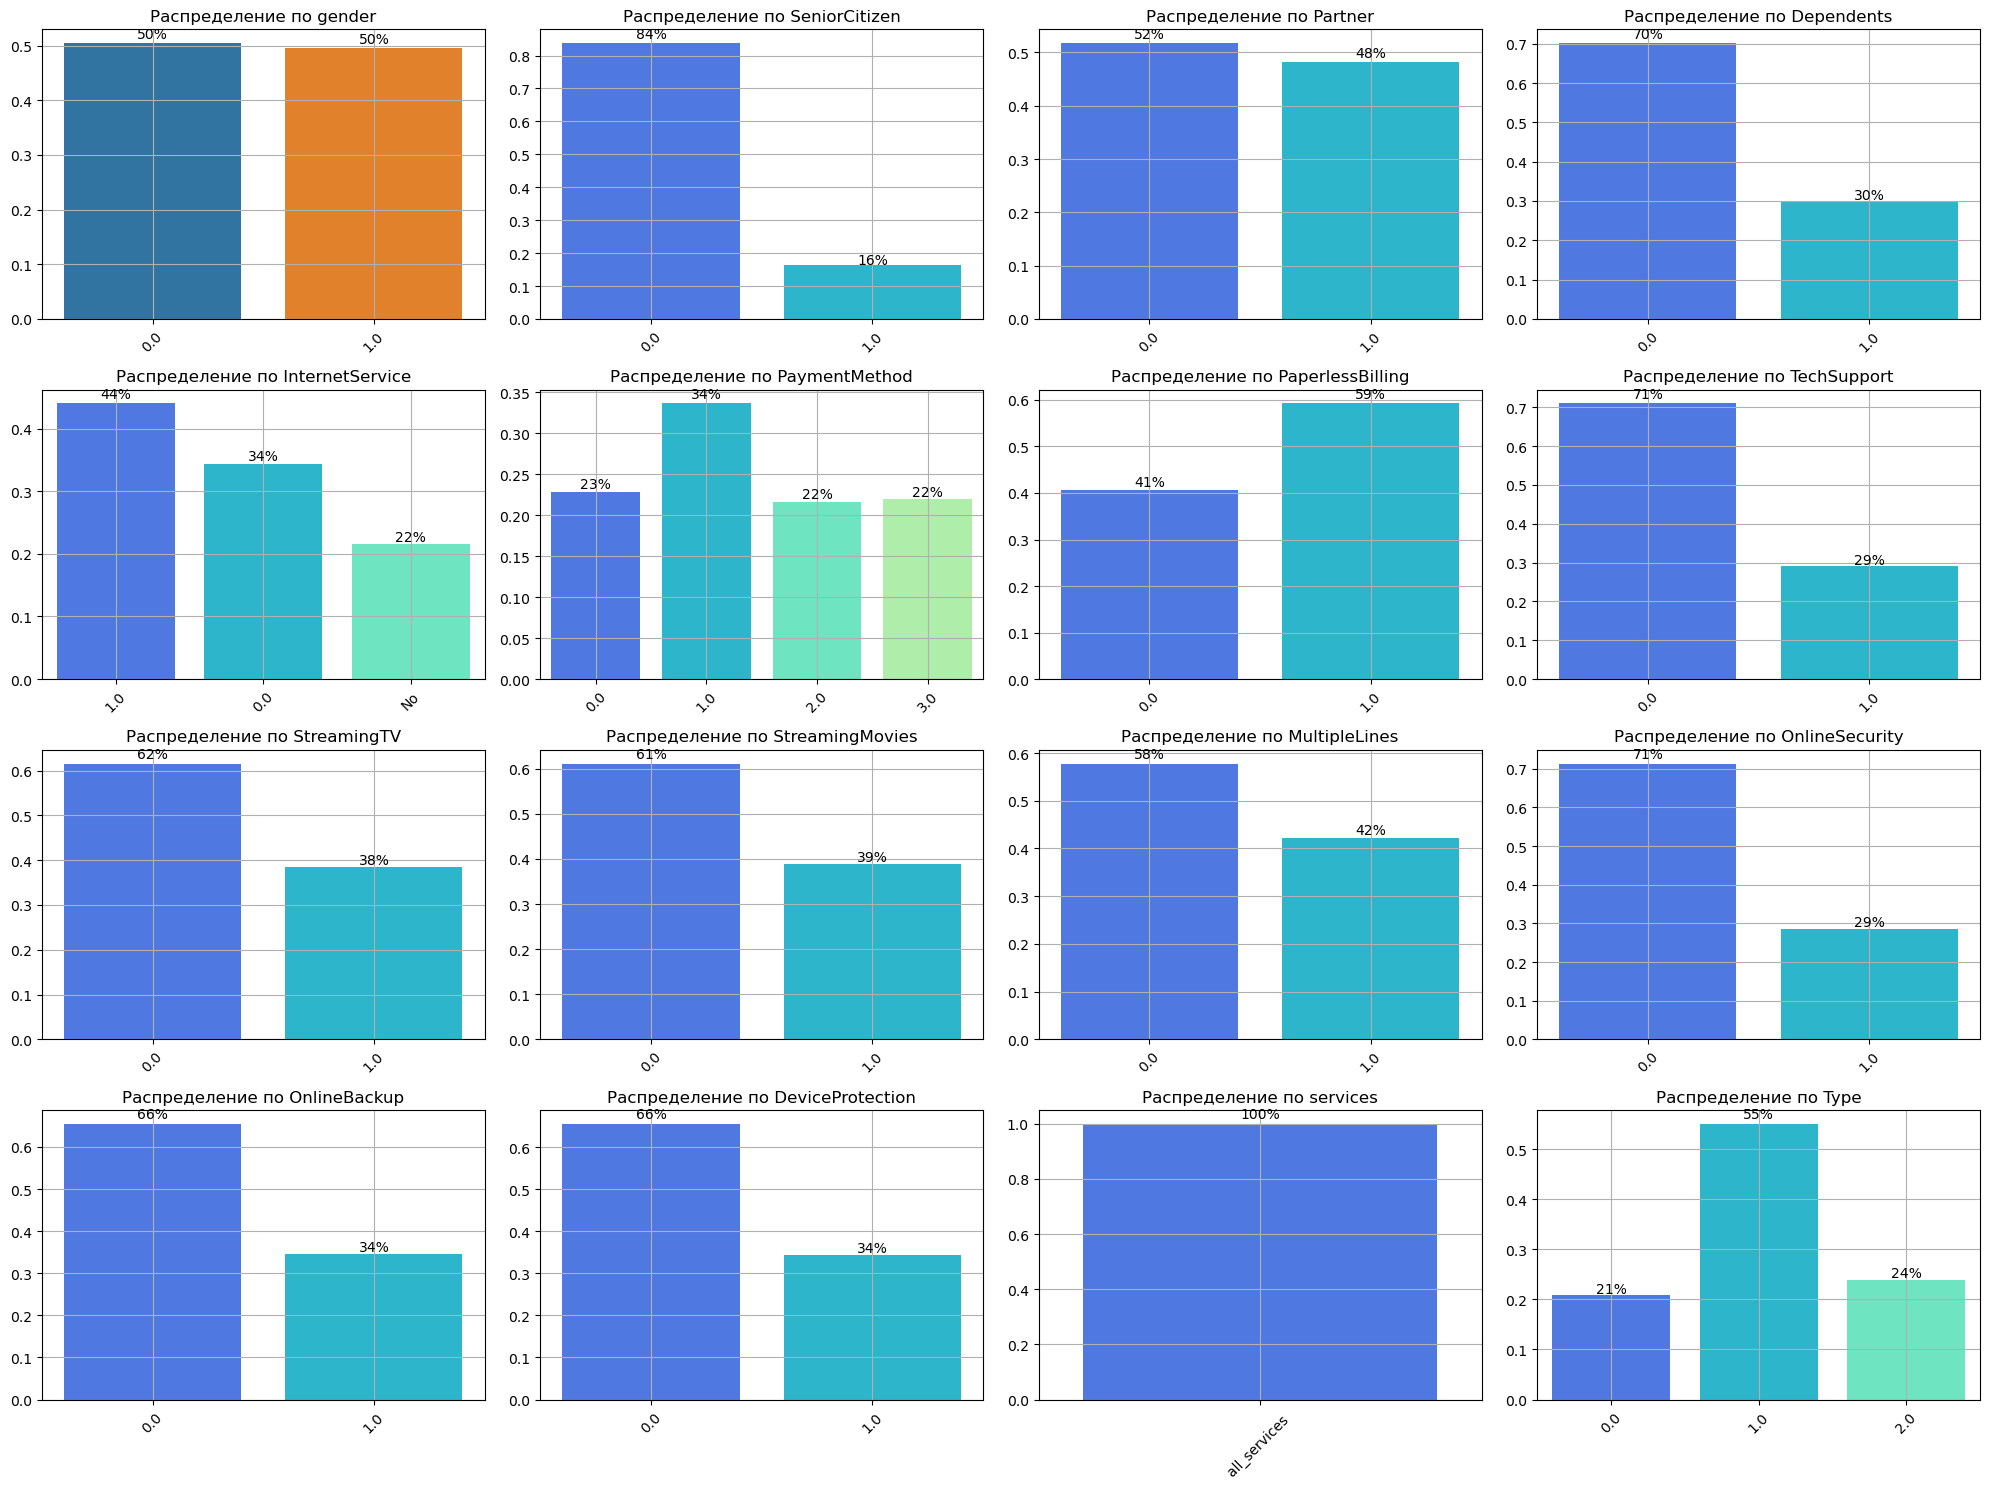

In [26]:
#0 - мужчины, 1 - женщины
main_columns_1 = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',  'InternetService', 
                  'PaymentMethod', 'PaperlessBilling', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 
                  'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'services', 'Type']

fig, axes = plt.subplots(4, 4, figsize=(20, 15))
# пройдемся по каждому основному столбцу
for ax, column in zip(axes.ravel(), main_columns_1):
    # посчитаем распределение по уникальным значениям столбца, сразу же нормализуем их
    data = (dataset[column].value_counts() / len(dataset)).to_frame().reset_index()
    sns.barplot(y=data.columns[1], x='index', data=data, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set(ylabel=None, xlabel=None)
    ax.set_title(f'Распределение по {column}')
    ax.grid()
    #ax.legent()
    sns.set_palette('rainbow')
    # добавим значения столбцов на диаграммы
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.0%}', (x+width/2, y+height*1.02), ha='center')

plt.tight_layout()
plt.show()

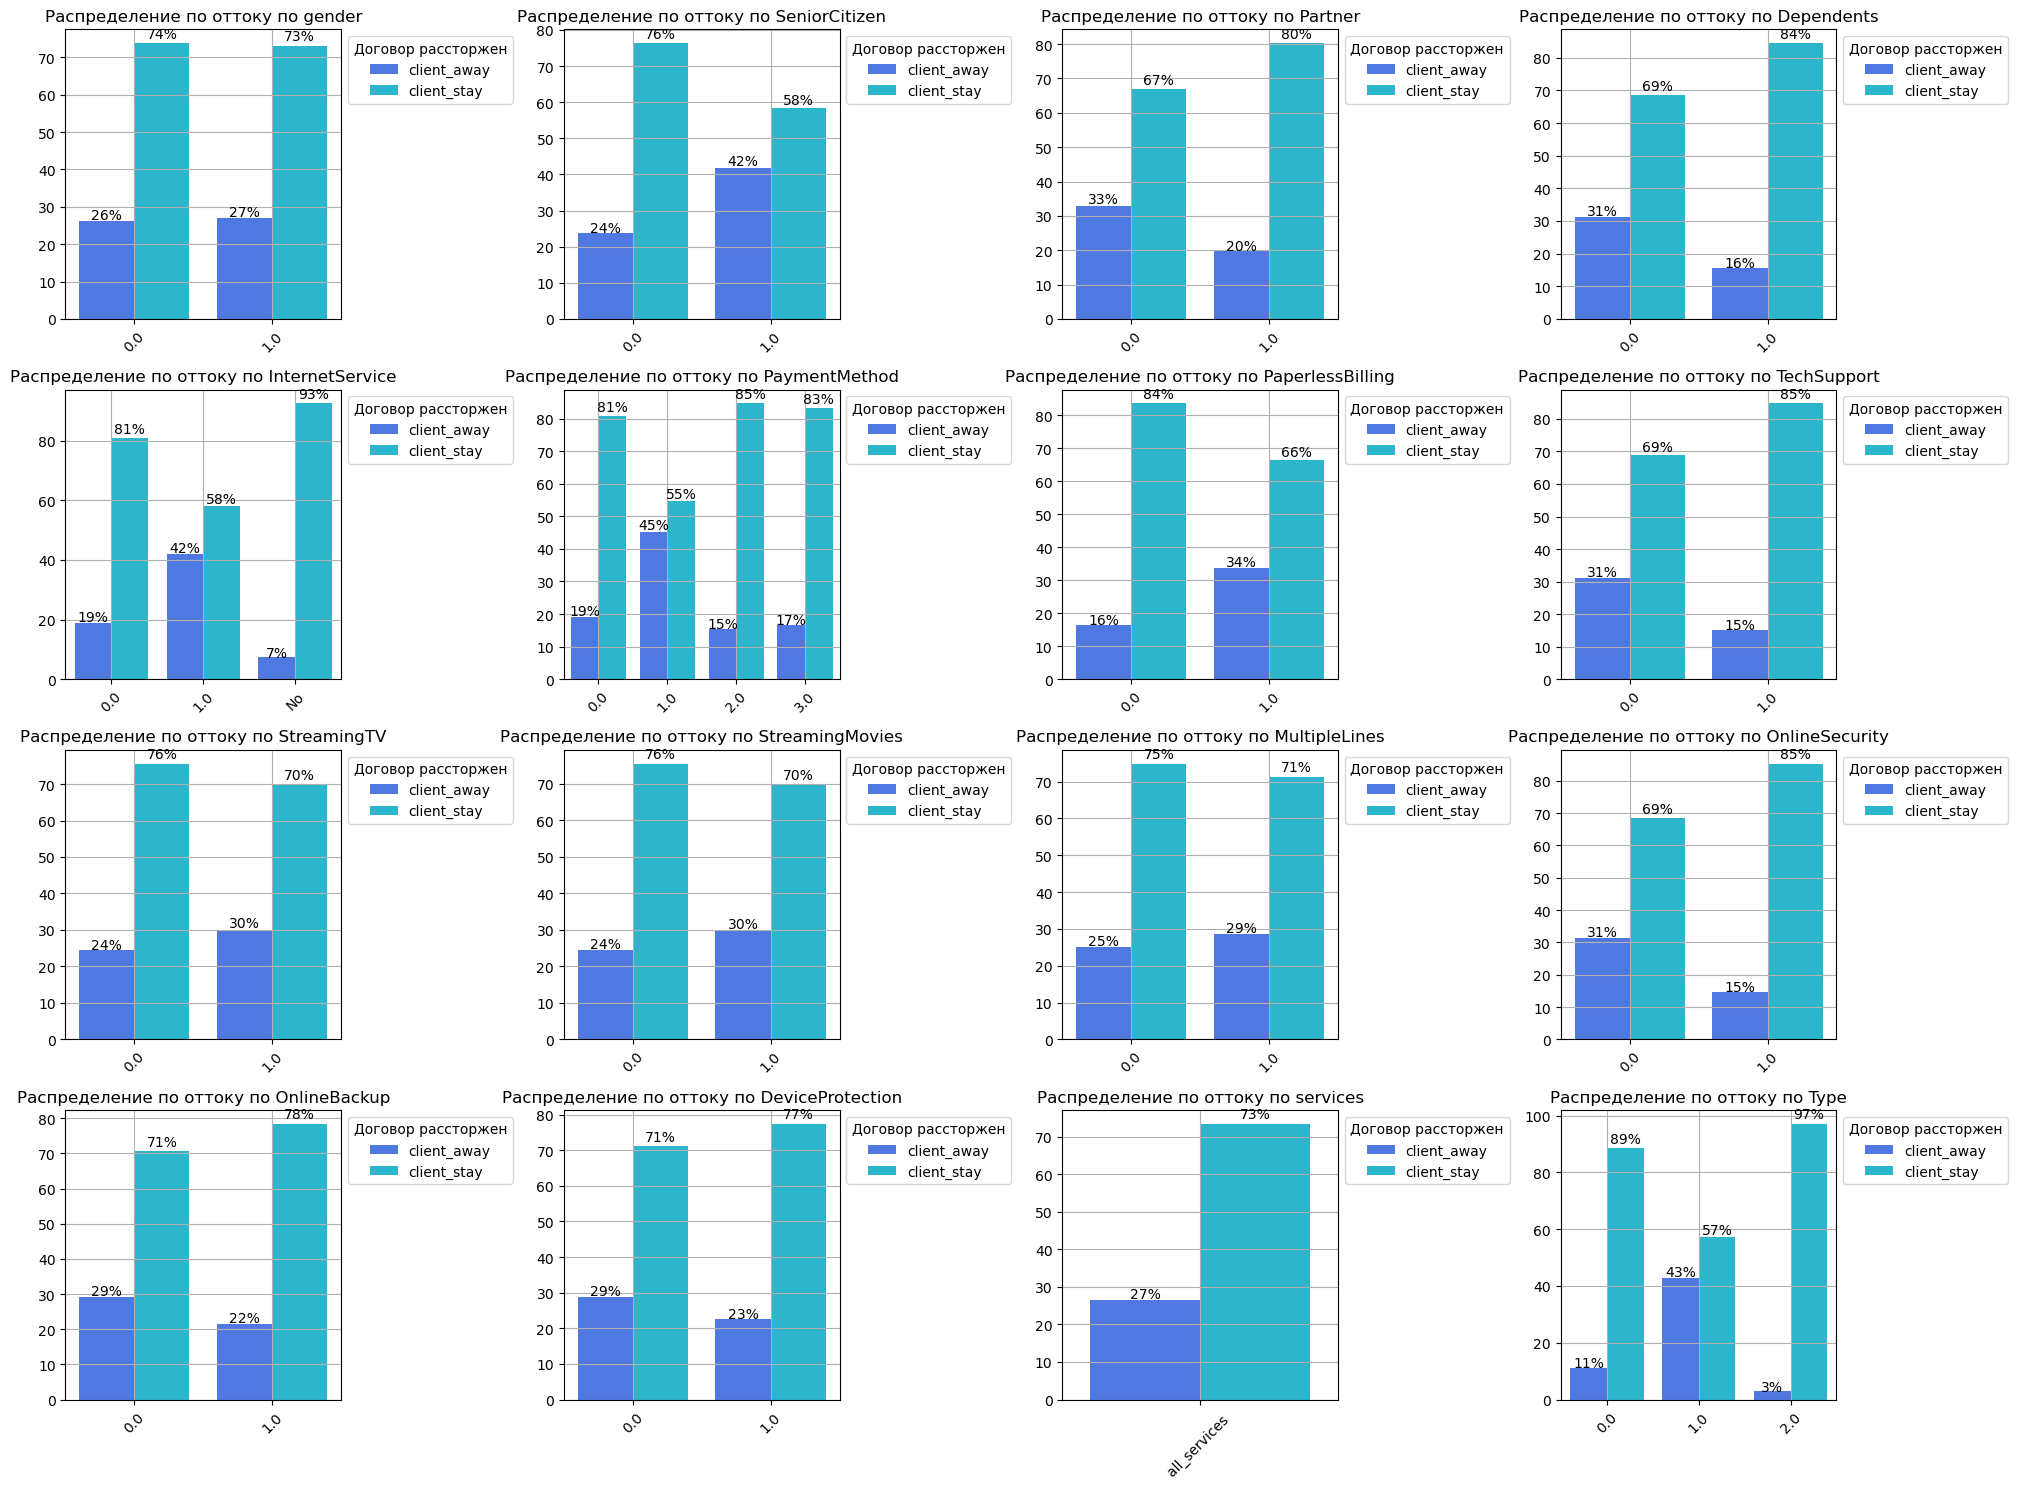

In [27]:
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
for ax, column in zip(axes.ravel(), main_columns_1):
    # нормализация данных
    data = dataset\
    .groupby(['churn', column])[column]\
    .count()\
    .groupby(column).apply(lambda x: 100 * x / x.sum())\
    .to_frame().stack().reset_index()

    sns.barplot(x=column, y=0, hue='churn', data=data, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set(ylabel=None, xlabel=None)
    ax.set_title(f'Распределение по оттоку по {column}')
    ax.legend(title='Договор рассторжен', loc=2, bbox_to_anchor=(1, 1), fontsize=10)
    ax.grid()
    sns.set_palette('rainbow')
    # добавим значения столбцов на диаграммы
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height/100:.0%}', (x+width/2, y+height*1.02), ha='center')
    # отразим на графике прямую, символизирующую пропорцию между глобальным churn/not churn
    #ax.axhline(26.5, c='r')
plt.tight_layout()
plt.show()